Having cleaned the data and made a couple of new features, we are ready to begin testing our models.

In [1]:
#import the necessities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import math
import warnings
from scipy.stats import bartlett, boxcox, jarque_bera, levene, normaltest, zscore
from scipy.stats.mstats import winsorize
from sklearn import ensemble
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.tree import DecisionTreeRegressor
from sqlalchemy import create_engine
from statsmodels.tools.eval_measures import mse, rmse
from xgboost import XGBClassifier
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#load our recently created cleaned datasets
cards = pd.read_csv('D:/DSF Files/cards.txt', sep='\t')
recent_cards = pd.read_csv('D:/DSF Files/recentcards.txt', sep = '\t')

In [3]:
#I'll be using the full cards list to test these so we'll call the
#head and the info to confirm the data loaded as needed
cards.head()

,White,Blue,Black,Red,Green,Uncommon,Rare,Mythic,Converted Mana Cost,Specific Mana Cost,Power,Toughness,Legendary,EG Keywords,Set Keywords
0,1,0,0,0,0,1,0,0,7,2,4,4,0,1,0
1,1,0,0,0,0,1,0,0,5,1,3,3,0,1,0
2,1,0,0,0,0,0,0,0,4,1,2,2,0,1,0
3,1,0,0,0,0,1,0,0,4,1,2,2,0,0,0
4,1,0,0,0,0,0,0,0,3,1,2,2,0,2,0


In [4]:
display(cards.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25032 entries, 0 to 25031
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   White                25032 non-null  int64
 1   Blue                 25032 non-null  int64
 2   Black                25032 non-null  int64
 3   Red                  25032 non-null  int64
 4   Green                25032 non-null  int64
 5   Uncommon             25032 non-null  int64
 6   Rare                 25032 non-null  int64
 7   Mythic               25032 non-null  int64
 8   Converted Mana Cost  25032 non-null  int64
 9   Specific Mana Cost   25032 non-null  int64
 10  Power                25032 non-null  int64
 11  Toughness            25032 non-null  int64
 12  Legendary            25032 non-null  int64
 13  EG Keywords          25032 non-null  int64
 14  Set Keywords         25032 non-null  int64
dtypes: int64(15)
memory usage: 2.9 MB


None

In [5]:
#I previously made these functions to quickly call the modeling method
#to compare them all quickly. we'll test them below

def tuning():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    print(results.summary())

def lrm_test():
    y = cards['Power']
    X = cards.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('OLS Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
    
def lasso_test():
    y = cards['Power']
    X = cards.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = LassoCV(cv=10)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

def ridge_test():
    y = cards['Power']
    X = cards.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = RidgeCV(cv=10)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('Ridge Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
    
def en_test():
    y = cards['Power']
    X = cards.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = ElasticNetCV(cv=10)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('Elastic Net Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

def lr_test(iter):
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=iter)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('Logistic Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

def rfc():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    rfc = ensemble.RandomForestClassifier()
    print('Random Forest Classifier')
    print(cross_val_score(rfc, X, y, cv=10))

def KNNc(n):
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    KNNc = KNeighborsClassifier(n_neighbors = n)
    print('K-Nearest Neighbors Classifier')
    print(cross_val_score(KNNc, X, y, cv=10))
    
def KNNr(n):
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    KNNr = KNeighborsRegressor(n_neighbors = n)
    KNNr.fit(X, y)
    print('K-Nearest Neighbors Regression')
    print(cross_val_score(KNNr, X, y, cv=10))
    
def SVC():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    svc = SVC()
    svc.fit(X, y)
    print(svc.score(X, y))

def LinearSVC():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    lsvc = LinearSVC()
    lsvc.fit(X, y)
    print(lsvc.score(X, y))

def SVR():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    svr = SVR()
    svr.fit(X, y)
    print(svr.score(X, y))

def d_tree(depth):
    y = cards['Power']
    X = cards.drop(['Power', 'Toughness'], axis=1)
    decision_tree = DecisionTreeRegressor(max_depth=depth)
    decision_tree.fit(X, y)
    print(decision_tree.score(X, y))
    score = cross_val_score(decision_tree, X, y, cv=10)
    print(score)

def d_tree_boosted(depth):
    predictions = pd.DataFrame()
    y = cards['Power']
    X = cards.drop(['Power', 'Toughness'], axis=1)
    for n in range(0, 100):
        decision_tree = DecisionTreeRegressor(max_depth=depth)
        decision_tree.fit(X, y)
        predict = decision_tree.predict(X)
        predictions['predictions {}'.format(n)] = predict
        y = y - predict
        if n % 20 == 0:
            print(decision_tree.score(X, y))
    predicted = predictions.sum(axis=1)
    print(np.corrcoef(cards['Power'], predicted)[0, 1])
    
def xgboost():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = XGBClassifier()
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('XGBoost Classifier')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

In [6]:
#a quick OLS to see what variables are important
tuning()

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     3324.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:06:12   Log-Likelihood:                -36956.
No. Observations:               25032   AIC:                         7.394e+04
Df Residuals:                   25017   BIC:                         7.406e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2794    

In [7]:
lr_test(5000)

Logistic Regression
R-squared of the model in the training set is: 0.4745568039950062
R-squared of the model in the test set is: 0.4531655682045137

Mean absolute error of the prediction is: 0.7187936888356301
Mean squared error of the prediction is: 1.231276e+00
Root mean squared error of the prediction is: 1.1096288628642363
Mean absolute percentage error of the prediction is: inf


In [8]:
rfc()

Random Forest Classifier
[0.78554313 0.77036741 0.73232121 0.72632841 0.7087495  0.7223332
 0.7107471  0.8174191  0.73232121 0.68837395]


In [9]:
KNNc(10)

K-Nearest Neighbors Classifier
[0.72004792 0.67851438 0.6504195  0.62365162 0.62085497 0.63483819
 0.61925689 0.64322813 0.63044347 0.62165402]


In [10]:
KNNr(10)

K-Nearest Neighbors Regression
[0.80161039 0.80286016 0.76836615 0.74339861 0.76156796 0.77120117
 0.77899983 0.82618119 0.76598143 0.7551057 ]


In [11]:
xgboost()

[22:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Classifier
R-squared of the model in the training set is: 0.7633957553058677
R-squared of the model in the test set is: 0.7098062712202916

Mean absolute error of the prediction is: 0.39524665468344317
Mean squared error of the prediction is: 6.916317e-01
Root mean squared error of the prediction is: 0.8316439836842221
Mean absolute percentage error of the prediction is: inf


In [12]:
lrm_test()

OLS Regression
R-squared of the model in the training set is: 0.564158708661681
R-squared of the model in the test set is: 0.5642082722702435

Mean absolute error of the prediction is: 0.8594936160674702
Mean squared error of the prediction is: 1.386844e+00
Root mean squared error of the prediction is: 1.1776432270593646
Mean absolute percentage error of the prediction is: inf


In [13]:
ridge_test()

Ridge Regression
R-squared of the model in the training set is: 0.564157884169622
R-squared of the model in the test set is: 0.5642062358049877

Mean absolute error of the prediction is: 0.8594932089617829
Mean squared error of the prediction is: 1.386850e+00
Root mean squared error of the prediction is: 1.1776459786337534
Mean absolute percentage error of the prediction is: inf


In [14]:
lasso_test()

R-squared of the model in the training set is: 0.564037404566766
R-squared of the model in the test set is: 0.5640456635950224

Mean absolute error of the prediction is: 0.8598278542345921
Mean squared error of the prediction is: 1.387361e+00
Root mean squared error of the prediction is: 1.1778629158841665
Mean absolute percentage error of the prediction is: inf


In [15]:
en_test()

Elastic Net Regression
R-squared of the model in the training set is: 0.5639619464921295
R-squared of the model in the test set is: 0.5639675028577186

Mean absolute error of the prediction is: 0.859909316132676
Mean squared error of the prediction is: 1.387610e+00
Root mean squared error of the prediction is: 1.1779684986255607
Mean absolute percentage error of the prediction is: inf


In [16]:
d_tree(4)

0.5685574463125451
[0.55128338 0.56956256 0.54481282 0.55325762 0.55851601 0.58900487
 0.53796622 0.58110849 0.55956885 0.54090272]


In [17]:
d_tree_boosted(4)

-6.298959526966144
-0.0033672976909093766
-0.0005400039636804799
-0.00045538619612472964
-0.000946253700470745
0.8287712484851347


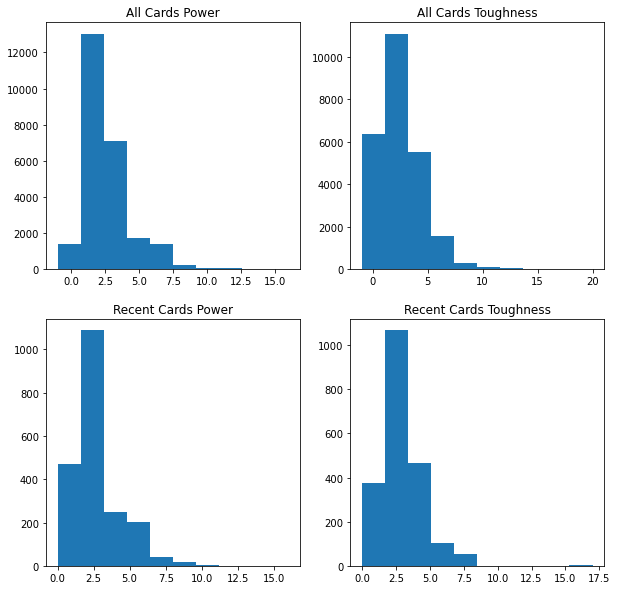

All Cards Power
Jarque-Bera test statistics is 19115.692674720853 and p value is 0.0
Normality test statistics is 6489.25986333034 and p value is 0.0
All Cards Toughness
Jarque-Bera test statistics is 23721.144458643732 and p value is 0.0
Normality test statistics is 6907.007496477227 and p value is 0.0
Recent Cards Power
Jarque-Bera test statistics is 1262.878561346418 and p value is 0.0
Normality test statistics is 459.22864491561324 and p value is 1.9044377898787476e-100
Recent Cards Toughness
Jarque-Bera test statistics is 6708.355469708132 and p value is 0.0
Normality test statistics is 811.7869657453906 and p value is 5.28080520612354e-177


In [18]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(cards['Power'])
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.hist(cards['Toughness'])
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.hist(recent_cards['Power'])
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.hist(recent_cards['Toughness'])
plt.title('Recent Cards Toughness')
plt.show()

jb_stats = jarque_bera(cards['Power'])
norm_stats = normaltest(cards['Power'])

print("All Cards Power")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(cards['Toughness'])
norm_stats = normaltest(cards['Toughness'])

print("All Cards Toughness")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Power")
jb_stats = jarque_bera(recent_cards['Power'])
norm_stats = normaltest(recent_cards['Power'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Toughness")
jb_stats = jarque_bera(recent_cards['Toughness'])
norm_stats = normaltest(recent_cards['Toughness'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Both the histograms and the Jarque-Bera and normality tests confirm that the data is not normally distributed. We'll attempt some data transformation.<br>
As a note, some of the values for power and toughness are either negative integers or zero, so we'll drop all negative values (3 rows) and convert all zero values to 0.0001 to allow for the transformation.

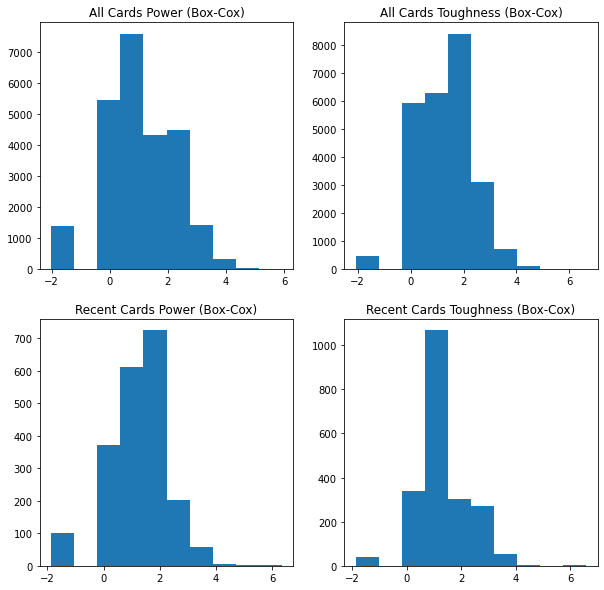

None
All Cards Power
Jarque-Bera test statistics is 1441.6605596810048 and p value is 0.0
Normality test statistics is 874.5659854557957 and p value is 1.2314285780173655e-190
All Cards Toughness
Jarque-Bera test statistics is 732.0896802160919 and p value is 0.0
Normality test statistics is 376.9059427188453 and p value is 1.431905773992689e-82
Recent Cards Power
Jarque-Bera test statistics is 138.51956958018664 and p value is 0.0
Normality test statistics is 82.28860341328578 and p value is 1.3528723072629497e-18
Recent Cards Toughness
Jarque-Bera test statistics is 223.8317972949073 and p value is 0.0
Normality test statistics is 77.20257371575896 and p value is 1.7205770401470827e-17


In [19]:
cards = cards[cards['Power'] >= 0]
cards = cards[cards['Toughness'] >= 0]
recent_cards = recent_cards[recent_cards['Power'] >= 0]
recent_cards = recent_cards[recent_cards['Toughness'] >= 0]

cards['Power'] = np.where(cards['Power'] == 0, 0.0001, cards['Power'])
cards['Toughness'] = np.where(cards['Toughness'] == 0, 0.0001, cards['Toughness'])
recent_cards['Power'] = np.where(recent_cards['Power'] == 0, 0.0001, recent_cards['Power'])
recent_cards['Toughness'] = np.where(recent_cards['Toughness'] == 0, 0.0001, recent_cards['Toughness'])

cards_Power_boxcox,_ = boxcox(cards['Power'])
cards_Toughness_boxcox,_ = boxcox(cards['Toughness'])
recent_cards_Power_boxcox,_ = boxcox(recent_cards['Power'])
recent_cards_Toughness_boxcox,_ = boxcox(recent_cards['Toughness'])

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(cards_Power_boxcox)
plt.title('All Cards Power (Box-Cox)')

plt.subplot(2, 2, 2)
plt.hist(cards_Toughness_boxcox)
plt.title('All Cards Toughness (Box-Cox)')

plt.subplot(2, 2, 3)
plt.hist(recent_cards_Power_boxcox)
plt.title('Recent Cards Power (Box-Cox)')

plt.subplot(2, 2, 4)
plt.hist(recent_cards_Toughness_boxcox)
plt.title('Recent Cards Toughness (Box-Cox)')
print(plt.show())

jb_stats = jarque_bera(cards_Power_boxcox)
norm_stats = normaltest(cards_Power_boxcox)

print("All Cards Power")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(cards_Toughness_boxcox)
norm_stats = normaltest(cards_Toughness_boxcox)

print("All Cards Toughness")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Power")
jb_stats = jarque_bera(recent_cards_Power_boxcox)
norm_stats = normaltest(recent_cards_Power_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Toughness")
jb_stats = jarque_bera(recent_cards_Toughness_boxcox)
norm_stats = normaltest(recent_cards_Toughness_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

The normality tests suggest that the data is now normally distributed though the Jarque-Bera does not. We'll run the tuning algorithm again to test.

In [ ]:
cards['Power'],_ = boxcox(cards['Power'])
cards['Toughness'],_ = boxcox(cards['Toughness'])
recent_cards['Power'],_ = boxcox(recent_cards['Power'])
recent_cards['Toughness'],_ = boxcox(recent_cards['Toughness'])

tuning()

We'll call the unaltered dataset again and attempt windorizing the data to limit the effect of the outliers.

In [ ]:
cards = pd.read_csv('D:/DSF Files/cards.txt', sep='\t')
recent_cards = pd.read_csv('D:/DSF Files/recentcards.txt', sep = '\t')

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.boxplot(cards['Power'])
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.boxplot(cards['Toughness'])
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.boxplot(recent_cards['Power'])
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.boxplot(recent_cards['Toughness'])
plt.title('Recent Cards Toughness')
plt.show()

In [ ]:
#use a z-score with a threshold of four to find any outliers
z_scores = zscore(cards['Power'])
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])
z_scores = zscore(cards['Toughness'])
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])
z_scores = zscore(recent_cards['Power'])
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])
z_scores = zscore(recent_cards['Toughness'])
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])

In [ ]:
win_cards_power = winsorize(cards['Power'], (0, 0.05))
win_cards_toughness = winsorize(cards['Toughness'], (0, 0.05))
win_recent_cards_power = winsorize(recent_cards['Power'], (0, 0.05))
win_recent_cards_toughness = winsorize(recent_cards['Toughness'], (0, 0.05))

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.boxplot(win_cards_power)
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.boxplot(win_cards_toughness)
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.boxplot(win_recent_cards_power)
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.boxplot(win_recent_cards_toughness)
plt.title('Recent Cards Toughness')
plt.show()

In [ ]:
z_scores = zscore(win_cards_power)
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])
z_scores = zscore(win_cards_toughness)
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])
z_scores = zscore(win_recent_cards_power)
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])
z_scores = zscore(win_recent_cards_toughness)
print(len(np.where(z_scores > 4)[0]))
display(np.where(z_scores > 4)[0])

In [ ]:
cards['Power'] = win_cards_power
cards['Toughness'] = win_cards_toughness
recent_cards['Power'] = win_recent_cards_power
recent_cards['Toughness'] = win_recent_cards_toughness

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(cards['Power'])
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.hist(cards['Toughness'])
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.hist(recent_cards['Power'])
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.hist(recent_cards['Toughness'])
plt.title('Recent Cards Toughness')
plt.show()

jb_stats = jarque_bera(cards['Power'])
norm_stats = normaltest(cards['Power'])

print("All Cards Power")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(cards['Toughness'])
norm_stats = normaltest(cards['Toughness'])

print("All Cards Toughness")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Power")
jb_stats = jarque_bera(recent_cards['Power'])
norm_stats = normaltest(recent_cards['Power'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Toughness")
jb_stats = jarque_bera(recent_cards['Toughness'])
norm_stats = normaltest(recent_cards['Toughness'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

A bit better but the data still isn't normalized. We'll check what the variables look like using the OLS and rerun the tests using the winsorized values.

In [ ]:
tuning()

In [ ]:
lr_test(5000)

In [ ]:
lrm_test()

In [ ]:
lasso_test()

In [ ]:
ridge_test()

In [ ]:
en_test()

In [ ]:
rfc()

In [ ]:
KNNc(5)

In [ ]:
KNNr(5)

In [ ]:
xgboost()

In [ ]:
d_tree(4)

In [ ]:
d_tree_boosted(4)

Based on these results, we'll use the boosted weak learner DecisionTreeRegressor.